# Regressing Litter on Deprivation in Glasgow City

This notebook performs data manipulation, exploration and analysis using count data regression models.

The objective is to determine whether one or more deprivation factors significantly increases or decreases the amount of litter in areas of Glasgow City.

## Data Preparation

- Read the data from a CSV file.
- Remove unnecessary columns.
- Assign valid data types.
- Impute missing values denoted by "*" with their mean.
- Impute missing values denoted by 0 with their mean.
- Split the data into training (70%), validation (20%) and test (10%) data sets.

In [136]:
import pandas as pd
import numpy as np

# The path to the file containing the deprivation and litter data.
data_fpath = "../data/glasgow-simd2020v2-extended.csv"

def remove_features(df):
  """Remove features from the data that we do not need"""
  columns_to_remove = [
    #"Total_population",
    #"Working_Age_population",
    "SIMD2020v2_Rank",
    "SIMD_2020v2_Percentile",
    "SIMD2020v2_Vigintile",
    "SIMD2020v2_Decile",
    "SIMD2020v2_Quintile",
    "SIMD2020v2_Income_Domain_Rank",
    "SIMD2020_Employment_Domain_Rank",
    "SIMD2020_Health_Domain_Rank",
    "SIMD2020_Education_Domain_Rank",
    "SIMD2020_Access_Domain_Rank",
    "SIMD2020_Crime_Domain_Rank",
    "SIMD2020_Housing_Domain_Rank"
  ]
  return df.drop(columns_to_remove, axis=1)

def impute_missing_data(df):
  """Replace missing values with their mean"""
  features = [
    "Total_population",
    "Working_Age_population",
    "CIF",
    "ALCOHOL",
    "DRUG",
    "SMR",
    "DEPRESS",
    "LBWT",
    "EMERG",
    "Attendance",
    "Attainment",
    "not_participating",
    "University",
    "crime_count",
    "crime_rate",
    "broadband"
  ]
  for f in features:
    df[f].fillna(df[f].mean(), inplace=True)
    df[f].replace(to_replace=0, value=df[f].mean(), inplace=True)
  return df

def impute_data_zones(df):
  """Impute missing values from data zone S01010206 using the zone next to it."""
  features = [
    "Total_population",
    "Working_Age_population",
    "income_rate",
    "income_count",
    "employment_rate",
    "employment_count"
  ]
  for f in features:
    dz1, dz2 = df.loc[df["Data_Zone"] == "S01010206"], df.loc[df["Data_Zone"] == "S01010207"]
    n = df.at[dz2.index[0], f]
    df.at[dz1.index[0], f] = n
  return df

def convert_float_feature_types(df):
  """Convert percentage strings to floats between 0-1"""
  to_float_features = [
    "income_rate",
    "employment_rate",
    "DEPRESS",
    "LBWT",
    "Attendance",
    "not_participating",
    "University",
    "overcrowded_rate",
    "nocentralheating_rate",
    "broadband"
  ]
  # These are not percentages
  df["crime_rate"] = df["crime_rate"].astype(float)
  df["crime_count"] = df["crime_count"].astype(float)
  df["Attainment"] = df["Attainment"].astype(float)
  for f in to_float_features:
    df[f] = df[f].str.rstrip("%").astype(float) / 100
  return df

def standardise_features(df):
  features = [
    "Total_population",
    "Working_Age_population",
    "income_rate",
    "income_count",
    "employment_rate",
    "employment_count",
    "CIF",
    "ALCOHOL",
    "DRUG",
    "SMR",
    "DEPRESS",
    "LBWT",
    "EMERG",
    "Attendance",
    "Attainment",
    "no_qualifications",
    "not_participating",
    "University",
    "drive_petrol",
    "drive_GP",
    "drive_post",
    "drive_primary",
    "drive_retail",
    "drive_secondary",
    "PT_GP",
    "PT_post",
    "PT_retail",
    "broadband",
    "crime_rate",
    "crime_count",
    "overcrowded_count",
    "overcrowded_rate",
    "nocentralheating_count",
    "nocentralheating_rate"
  ]
  sdf = df[features]
  df[features] = (sdf - sdf.mean()) / sdf.std()
  return df

def convert_categorical_feature_types(df):
  """Convert strings to categorical features"""
  to_category_features = [
    "Data_Zone",
    "Intermediate_Zone",
    "Council_area"
  ]
  for f in to_category_features:
    df[f] = df[f].astype("category")
  return df

def convert_feature_types(df):
  """Convert features to the correct types"""
  df = df.replace("*", np.NaN)
  df = convert_float_feature_types(df)
  return convert_categorical_feature_types(df)

def read_data_from_file(fpath):
  """Read the data from file, handle missing data and assign feature types"""
  df = pd.read_csv(fpath, header=0)
  df = remove_features(df)
  df = convert_feature_types(df)
  df = impute_missing_data(df)
  #df = standardise_features(df)
  return df

def split_data(df, valid_frac=0.2, test_frac=0.1, random_state=1):
  """Split into train/valid/test data (default 70%/20%/10%)"""
  train_frac = 1 - valid_frac - test_frac
  return np.split(
    df.sample(frac=1, random_state=random_state),
    [int(train_frac * len(df)), int((train_frac + valid_frac) * len(df))],
  )

def get_split_data(random_state=None):
  """Get a dataframe of the data split into train/valid/test (70%/20%/10%)"""
  df = read_data_from_file(data_fpath)
  return split_data(df, random_state=random_state)

View how many observations we have in each data set:

In [137]:
df_train, df_valid, df_test = get_split_data()

print("Training data: {} observations".format(len(df_train)))
print("Validation data: {} observations".format(len(df_valid)))
print("Test data: {} observations".format(len(df_test)))

Training data: 522 observations
Validation data: 149 observations
Test data: 75 observations


Verify that the factor data types are correct and that there are no missing values:

In [138]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 522 entries, 432 to 526
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Data_Zone                522 non-null    category
 1   Intermediate_Zone        522 non-null    category
 2   Council_area             522 non-null    category
 3   Total_population         522 non-null    float64 
 4   Working_Age_population   522 non-null    float64 
 5   income_rate              522 non-null    float64 
 6   income_count             522 non-null    int64   
 7   employment_rate          522 non-null    float64 
 8   employment_count         522 non-null    int64   
 9   CIF                      522 non-null    float64 
 10  ALCOHOL                  522 non-null    float64 
 11  DRUG                     522 non-null    float64 
 12  SMR                      522 non-null    float64 
 13  DEPRESS                  522 non-null    float64 
 14  LBWT    

In [139]:
df_train.isnull().sum()

Data_Zone                  0
Intermediate_Zone          0
Council_area               0
Total_population           0
Working_Age_population     0
income_rate                0
income_count               0
employment_rate            0
employment_count           0
CIF                        0
ALCOHOL                    0
DRUG                       0
SMR                        0
DEPRESS                    0
LBWT                       0
EMERG                      0
Attendance                 0
Attainment                 0
no_qualifications          0
not_participating          0
University                 0
crime_count                0
crime_rate                 0
overcrowded_count          0
nocentralheating_count     0
overcrowded_rate           0
nocentralheating_rate      0
drive_petrol               0
drive_GP                   0
drive_post                 0
drive_primary              0
drive_retail               0
drive_secondary            0
PT_GP                      0
PT_post       

## Data Exploration

- Total population ranges between 288 - 2544 per data zone.
- Working age population ranges between 165 - 2361 per data zone.
- On average, 19% are income deprived.
- On average, 14% are employment deprived.
- On average, 21% are prescribed drugs for anxiety, depression or psychosis.
- On average, 7% of births are live singleton or low weight.
- On average, there is a 76% pupil attendance at school.
- On average, the attainment score of school leavers is 5.4.
- On average, 5% of 16 - 19 year olds are not in education, employment or training.
- On average, 8% of 17 - 21 year olds are entering university.
- On average, the comparative illness factor ratio is 152 (100 is Scottish average.)
- On average, the standardised mortality ratio is 121 (100 is Scottish average.)
- On average, the hospital stays related to alcohol misuse ratio is 178 (100 is Scottish average.)
- On average, the hospital stays related to drug misuse ratio is 173 (100 is Scottish average.)
- On average, the emergency hospital stays ratio is 121 (100 is Scottish average.)
- On average, the working age population with no qualifications ratio is 148 (100 is Scottish average.)
- On average, it's a 3.1 minute drive to a petrol station.
- On average, it's a 2.3 minute drive to a GP.
- On average, it's a 7.1 minute journey to a GP via public transport.
- On average, it's a 2.3 minute drive to a post office.
- On average, it's a 7.1 minute journey to a post office via public transport.
- On average, it's a 2.6 minute drive to a primary school.
- On average, it's a 4.2 minute drive to a secondary school.
- On average, it's a 3.5 minute drive to a retail centre.
- On average, it's a 9.5 minute journey to a retail centre via public transport.
- On average, 2% of premises do not have access to superfast broadband.
- On average, there are 440 incidents of crime per 10,000 people.
- On average, 21% are in overcrowded households.
- On average, 3% are in households without central heating.
- Litter ranges between 0 - 58 per data zone.
- On average, there are 10 littered objects per 50 images per data zone.

In [140]:
df_train.describe()

,Total_population,Working_Age_population,income_rate,income_count,employment_rate,employment_count,CIF,ALCOHOL,DRUG,SMR,...,drive_post,drive_primary,drive_retail,drive_secondary,PT_GP,PT_post,PT_retail,broadband,public_recycling_points,litter
count,522.000000,522.000000,522.000000,522.00000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,...,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000
mean,834.299744,588.791211,0.197490,159.41954,0.141648,77.498084,152.265409,175.107280,167.011649,125.902299,...,2.349133,2.635252,3.495995,4.231485,7.089275,7.064384,9.538043,0.028736,1.024904,10.392720
std,252.708618,235.783222,0.119587,101.02932,0.089142,49.876286,70.767353,144.180975,149.984202,71.651428,...,0.811050,0.888605,1.327037,1.361489,3.044694,2.474557,3.431997,0.047019,1.519342,7.514349
min,260.000000,161.000000,0.000000,0.00000,0.000000,0.000000,5.000000,6.000000,7.000000,8.000000,...,0.667906,0.979924,0.843476,1.290801,1.595565,1.937586,2.289857,0.010000,0.000000,0.000000
25%,685.500000,453.000000,0.090000,70.00000,0.060000,35.000000,95.000000,75.250000,59.000000,88.000000,...,1.743877,1.981215,2.601035,3.224493,4.884826,5.290415,7.051178,0.015538,0.000000,5.000000
50%,801.000000,550.000000,0.190000,150.50000,0.130000,70.500000,155.000000,148.000000,139.000000,116.000000,...,2.234152,2.536781,3.380436,4.038815,6.673790,6.780890,9.218307,0.015538,0.000000,9.000000
75%,931.000000,662.000000,0.290000,231.75000,0.207500,110.000000,205.000000,237.750000,225.000000,146.000000,...,2.861963,3.096639,4.357574,5.122868,8.770271,8.248951,11.762133,0.015538,2.000000,14.000000
max,2544.000000,2361.000000,0.590000,656.00000,0.440000,283.000000,370.000000,1656.000000,1316.000000,824.000000,...,4.603830,5.471867,8.521768,8.467000,21.908923,16.288734,23.645457,0.400000,9.000000,58.000000


In [141]:
df_train.head()

,Data_Zone,Intermediate_Zone,Council_area,Total_population,Working_Age_population,income_rate,income_count,employment_rate,employment_count,CIF,...,drive_post,drive_primary,drive_retail,drive_secondary,PT_GP,PT_post,PT_retail,broadband,public_recycling_points,litter
432,S01010190,Robroyston and Millerston,Glasgow City,908.0,682.0,0.03,31,0.03,21,35.0,...,4.545780,3.763552,3.678348,5.268902,11.621676,12.952385,8.556453,0.015538,0,2
596,S01010354,Maryhill West,Glasgow City,786.0,529.0,0.27,213,0.18,95,210.0,...,1.666306,2.383758,3.354297,3.925619,13.257759,5.401596,8.696576,0.015538,0,3
312,S01010070,Shettleston South,Glasgow City,636.0,476.0,0.06,35,0.06,26,105.0,...,2.580113,4.256550,1.809714,5.140043,10.265921,7.712060,6.577060,0.015538,0,18
204,S01009962,Muirend and Old Cathcart,Glasgow City,959.0,704.0,0.11,105,0.09,62,90.0,...,2.420774,3.012314,1.023257,4.066433,2.957825,5.450078,2.934723,0.015538,1,4
357,S01010115,"Garthamlock, Auchinlea and Gartloch",Glasgow City,602.0,435.0,0.15,91,0.10,42,165.0,...,2.531875,3.342057,3.408782,6.410159,9.947654,10.683509,7.756242,0.120000,0,5


### Correlations

The positive correlations (>= .3) are no_qualifications, income_rate, CIF, employment_rate, EMERG, DEPRESS, SMR and ALCOHOL.

The negative correlations (>= .3) are Attainment and Attendance.

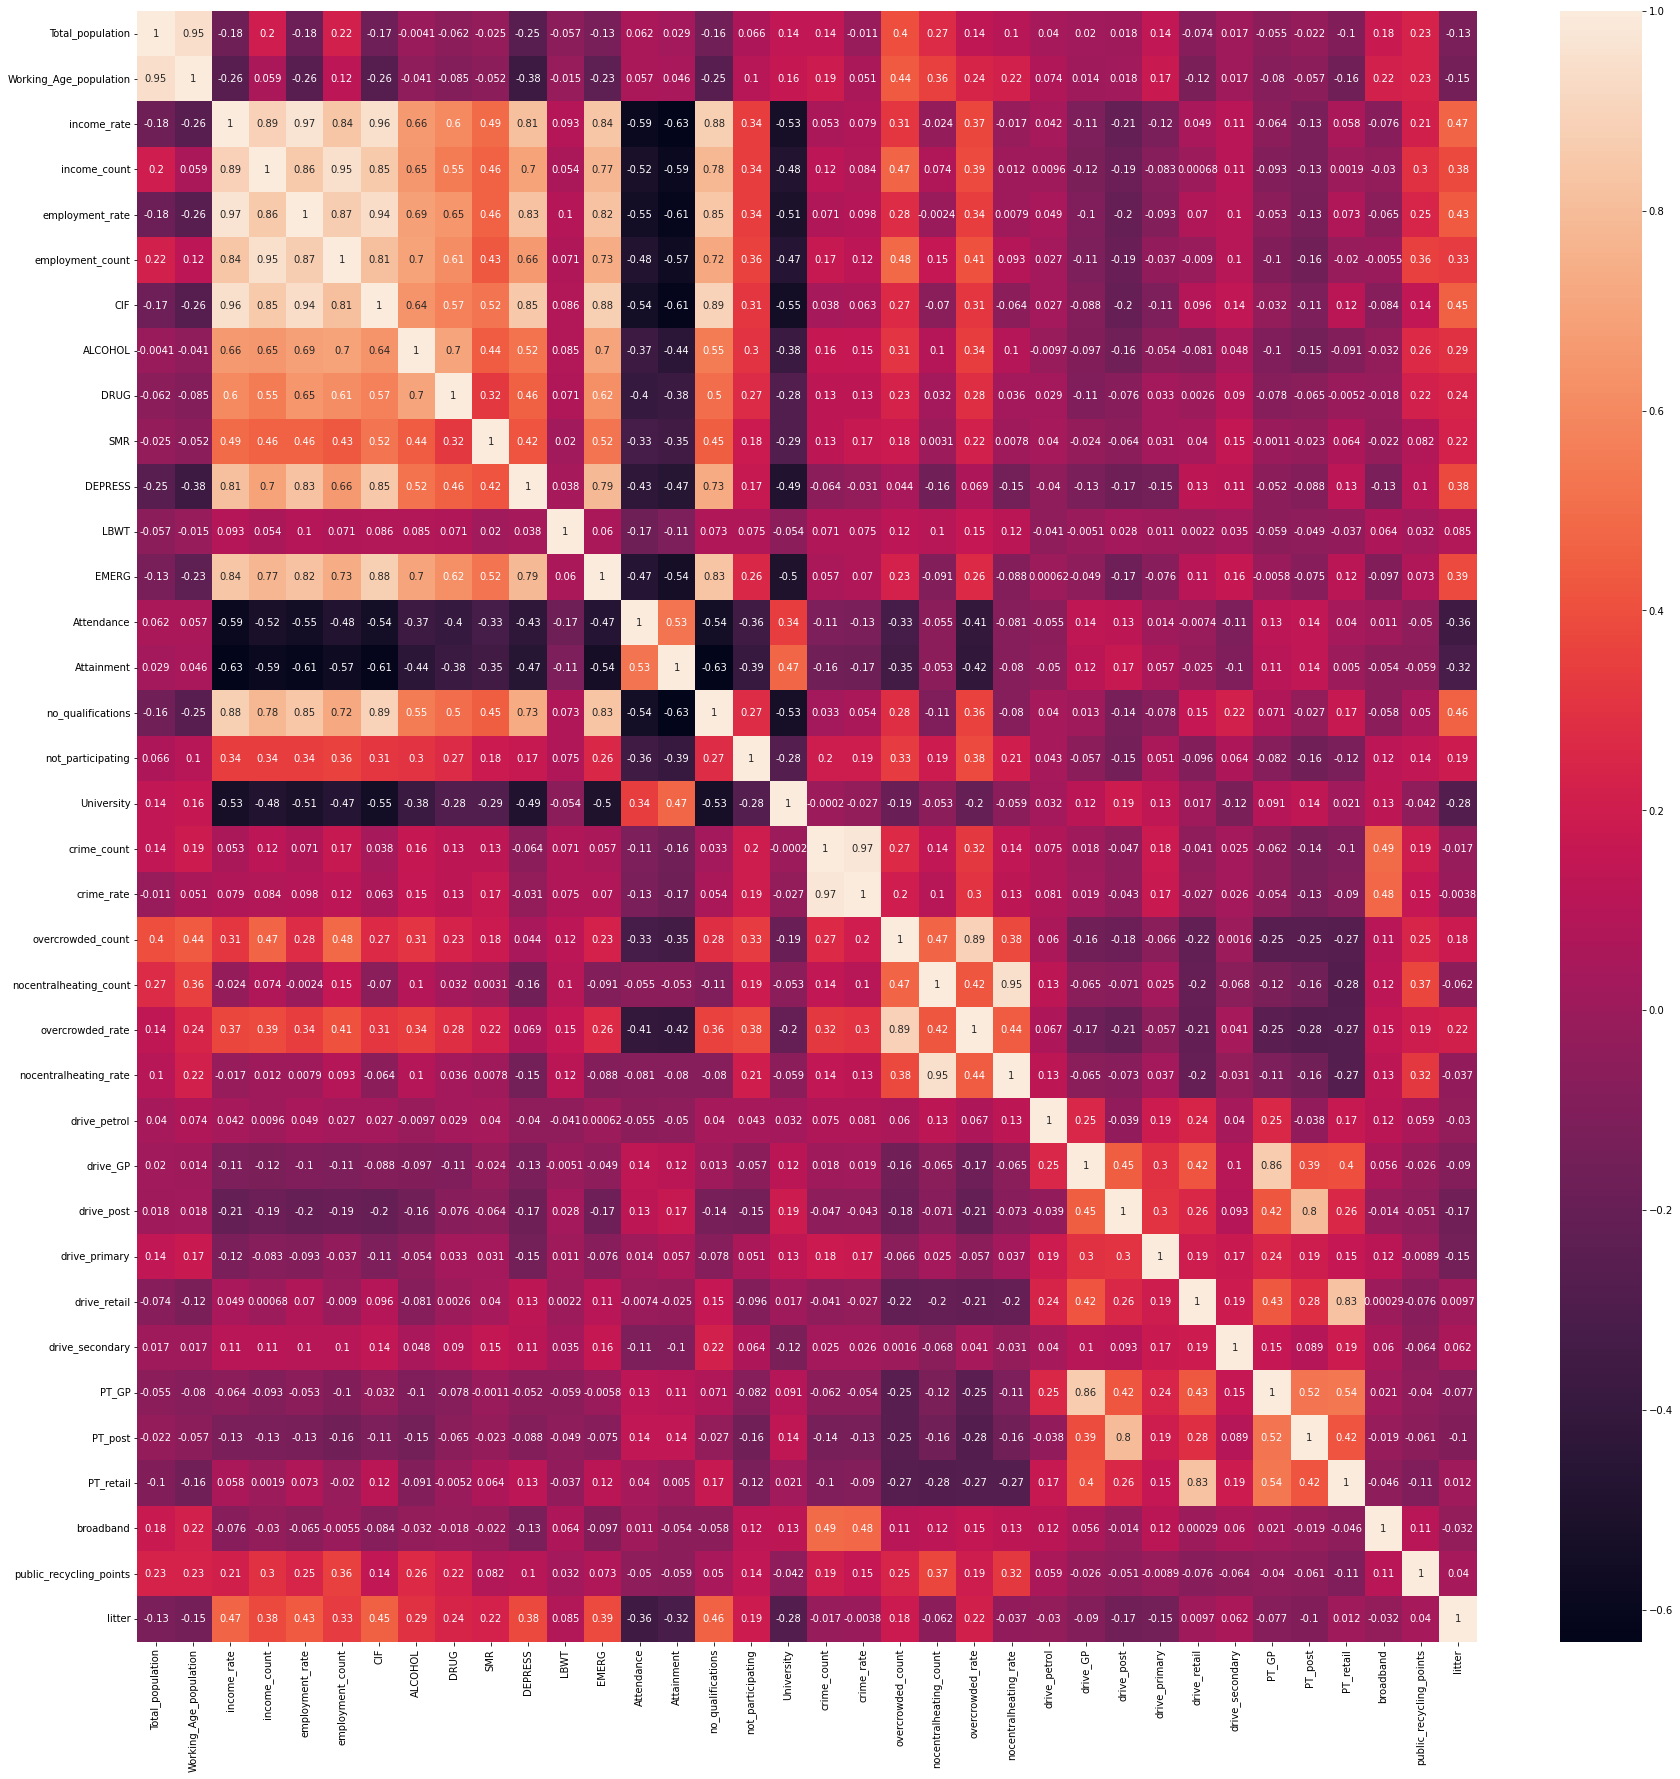

In [142]:
import seaborn as sn
import matplotlib.pyplot as plt

def plot_correlation_matrix(df, columns, figsize=(10,10)):
  plt.figure(figsize=figsize)
  corr_df = pd.DataFrame(df, columns=columns)
  sn.heatmap(corr_df.corr(), annot=True)
  plt.show()

plot_correlation_matrix(df_train, df_train.columns, figsize=(30,30))

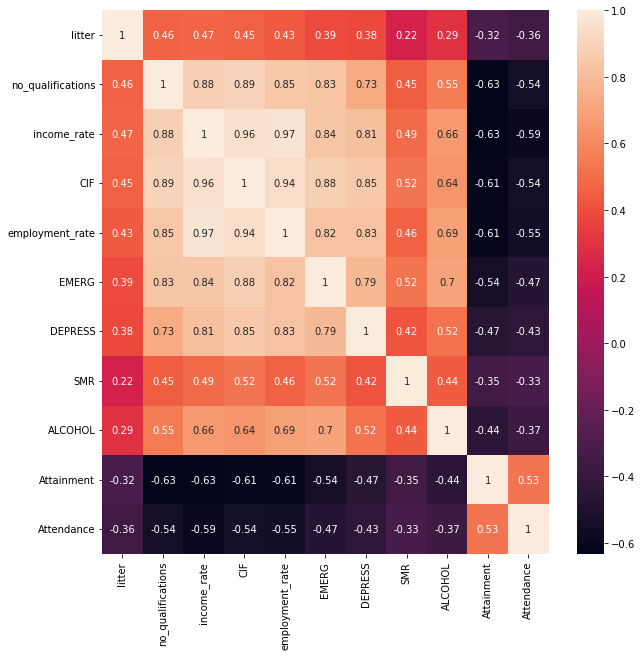

In [143]:
features_with_corr = [
  "litter",
  # Positive
  "no_qualifications",
  "income_rate",
  "CIF",
  "employment_rate",
  "EMERG",
  "DEPRESS",
  "SMR",
  "ALCOHOL",
  # Negative
  "Attainment",
  "Attendance"
]

plot_correlation_matrix(df_train, columns=features_with_corr)

## Visualise

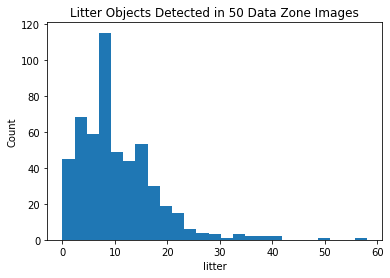

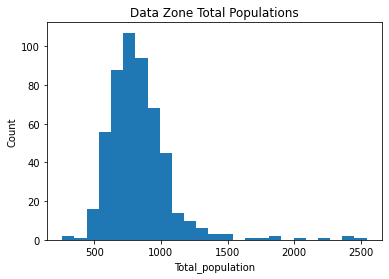

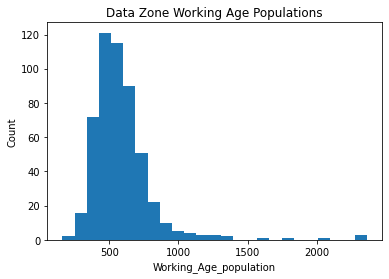

In [144]:
def plot_histogram(column, title, bins=25):
  ax = df_train.hist(column=column, bins=bins, grid=False)
  for x in ax[0]:
    x.set_title(title)
    x.set_xlabel(column)
    x.set_ylabel("Count")

plot_histogram("litter", title="Litter Objects Detected in 50 Data Zone Images")
plot_histogram("Total_population", title="Data Zone Total Populations")
plot_histogram("Working_Age_population", title="Data Zone Working Age Populations")

## Standardise

Standardise the predictors for regression as they are in different units.

In [145]:
df_train = standardise_features(df_train)
df_valid = standardise_features(df_valid)
df_test = standardise_features(df_test)

## Poission

Train a Poisson regression model using forward variable selection.

In [146]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices

def forward_selection(df, response, smf_model=smf.poisson, family=sm.families.Poisson()):
    remaining = set(df.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = float('inf'), float('inf')
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {}".format(response, ' + '.join(selected + [candidate]))
            model = smf_model(formula, df).fit(method="newton")
            score = model.aic
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        print(f"current_score ({current_score}) > best_new_score ({best_new_score})")
        if current_score > best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
            print("Best new score:", best_new_score)
            print("Selected:", selected)
            print("Remaining:", remaining)
            print()
    print("Best score:", best_new_score)
    print("Selected:", selected)
    print("Remaining:", remaining)
    formula = "{} ~ {}".format(response, ' + '.join(selected))
    print("CHOSEN FORMULA: ", formula)
    y_train, X_train = dmatrices(formula, df, return_type="dataframe")
    model = sm.GLM(y_train, X_train, family=family).fit()
    return model

#df_train_in = df_train.drop(["Data_Zone", "Intermediate_Zone", "Council_area"], axis=1)
df_train_in = df_train[features_with_corr]
poisson_model = forward_selection(df_train_in, "litter")

Optimization terminated successfully.
         Current function value: 3.910225
         Iterations 5
Optimization terminated successfully.
         Current function value: 4.132845
         Iterations 5
Optimization terminated successfully.
         Current function value: 3.822719
         Iterations 5
Optimization terminated successfully.
         Current function value: 3.843611
         Iterations 5
Optimization terminated successfully.
         Current function value: 4.056885
         Iterations 5
Optimization terminated successfully.
         Current function value: 4.018811
         Iterations 5
Optimization terminated successfully.
         Current function value: 4.208927
         Iterations 6
Optimization terminated successfully.
         Current function value: 4.026286
         Iterations 5
Optimization terminated successfully.
         Current function value: 3.809105
         Iterations 5
Optimization terminated successfully.
         Current function value: 4.290806
  

In [147]:
print(poisson_model.summary())
print("AIC:", poisson_model.aic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 litter   No. Observations:                  522
Model:                            GLM   Df Residuals:                      511
Model Family:                 Poisson   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1945.3
Date:                Sat, 16 Apr 2022   Deviance:                       1842.3
Time:                        20:41:42   Pearson chi2:                 1.92e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.7395
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.2754      0.01

The model does not fit as its pearson chi squared value is greater than expected.

In [148]:
from scipy.stats import chi2

def check_pearson_chi2(pearson_chi2, residuals):
  chi_sq = chi2.ppf(.05, df=residuals)
  print("Pearson Chi Sq <= Chi Sq")
  print(f"{pearson_chi2} <= {chi_sq}")
  print(f"The model fits: {pearson_chi2 <= chi_sq}")

check_pearson_chi2(pearson_chi2=poisson_model.pearson_chi2, residuals=poisson_model.df_resid)

Pearson Chi Sq <= Chi Sq
1924.3124375105758 <= 459.5774428416623
The model fits: False


## Negative Binomial

Train a negative binomial regression model using forward variable selection.

In [149]:
nb_model = forward_selection(df_train_in, "litter", smf_model=smf.negativebinomial, family=sm.families.NegativeBinomial(alpha=0.4))

Optimization terminated successfully.
         Current function value: 3.130086
         Iterations 4
Optimization terminated successfully.
         Current function value: 3.181868
         Iterations 5
Optimization terminated successfully.
         Current function value: 3.108388
         Iterations 4
Optimization terminated successfully.
         Current function value: 3.113944
         Iterations 5
Optimization terminated successfully.
         Current function value: 3.164591
         Iterations 4
Optimization terminated successfully.
         Current function value: 3.158652
         Iterations 5
Optimization terminated successfully.
         Current function value: 3.194691
         Iterations 5
Optimization terminated successfully.
         Current function value: 3.152683
         Iterations 5
Optimization terminated successfully.
         Current function value: 3.104075
         Iterations 4
Optimization terminated successfully.
         Current function value: 3.209688
  

The model does fit:

In [150]:
print(nb_model.summary())
print("AIC:", nb_model.aic)
check_pearson_chi2(pearson_chi2=nb_model.pearson_chi2, residuals=nb_model.df_resid)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 litter   No. Observations:                  522
Model:                            GLM   Df Residuals:                      511
Model Family:        NegativeBinomial   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1623.0
Date:                Sat, 16 Apr 2022   Deviance:                       396.19
Time:                        20:41:43   Pearson chi2:                     374.
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2361
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.2736      0.03

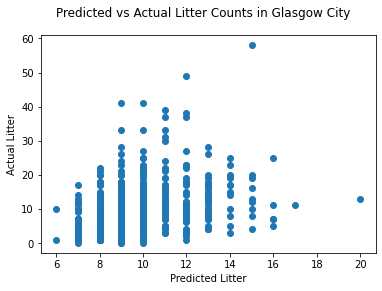

In [151]:
import matplotlib.pyplot as plt

def get_predicted_counts(model, X):
    predictions = model.get_prediction(X)
    df_predictions = predictions.summary_frame()
    return round(df_predictions["mean"])

def scatter_plot(df, formula, model):
    y, X = dmatrices(formula, df, return_type="dataframe")
    predicted_counts, actual_counts = get_predicted_counts(model, X), y["litter"]
    fig = plt.figure()
    fig.suptitle("Predicted vs Actual Litter Counts in Glasgow City")
    plt.scatter(x=predicted_counts, y=actual_counts)
    plt.xlabel("Predicted Litter")
    plt.ylabel("Actual Litter")
    plt.show()

nb_model_formula = "litter ~ ALCOHOL + SMR + Attainment + DEPRESS + EMERG + employment_rate + CIF + Attendance + income_rate + no_qualifications"
scatter_plot(df_train_in, nb_model_formula, nb_model)

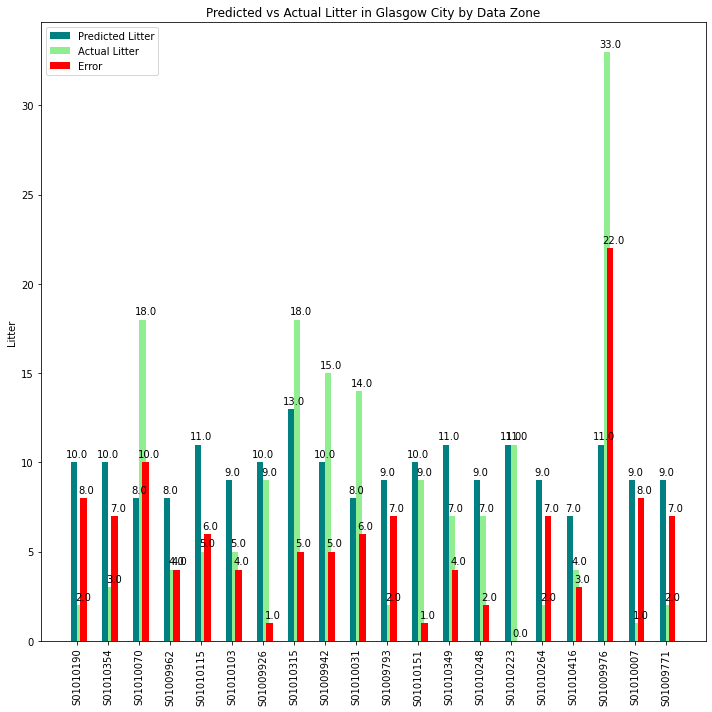

In [152]:
def bar_plot(df, formula, model, n_bars=20, bar_width=0.2):
    y, X = dmatrices(formula, df, return_type="dataframe")
    indices = X.index[:n_bars]
    labels = read_data_from_file(data_fpath).iloc[indices]["Data_Zone"]
    predicted_counts, actual_counts = get_predicted_counts(model, X), y["litter"]
    y_predicted = predicted_counts[:n_bars]
    y_actual = actual_counts[:n_bars]
    y_err = abs(y_predicted - y_actual)

    fig, ax = plt.subplots()
    fig.set_figwidth(10)
    fig.set_figheight(10)
    x = np.arange(len(labels))
    rects1 = ax.bar(x - bar_width/2, y_predicted, bar_width, label="Predicted Litter", color="teal")
    rects2 = ax.bar(x + bar_width/2, y_actual, bar_width, label="Actual Litter", color="lightgreen")
    rects3 = ax.bar(x + (bar_width/2) + (bar_width/2), y_err, bar_width, label="Error", color="red")
    ax.set_ylabel("Litter")
    ax.set_title("Predicted vs Actual Litter in Glasgow City by Data Zone")
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=90)
    ax.legend()
    for rects in [rects1, rects2, rects3]:
        for rect in rects:
            height = rect.get_height()
            ax.annotate(
                f"{height}",
                xy=(rect.get_x() + rect.get_width() / 2 + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha="center", va='bottom'
        )
    fig.tight_layout()
    plt.show()

bar_plot(df_train_in, nb_model_formula, nb_model)

### Validation

Use the validation data set this time.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 litter   No. Observations:                  149
Model:                            GLM   Df Residuals:                      138
Model Family:        NegativeBinomial   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -459.78
Date:                Sat, 16 Apr 2022   Deviance:                       97.436
Time:                        20:41:43   Pearson chi2:                     104.
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2853
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.2797      0.05

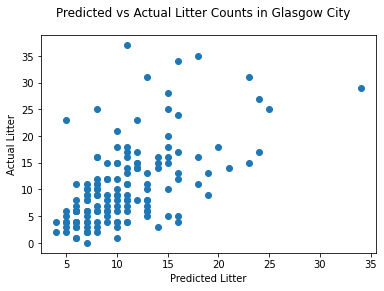

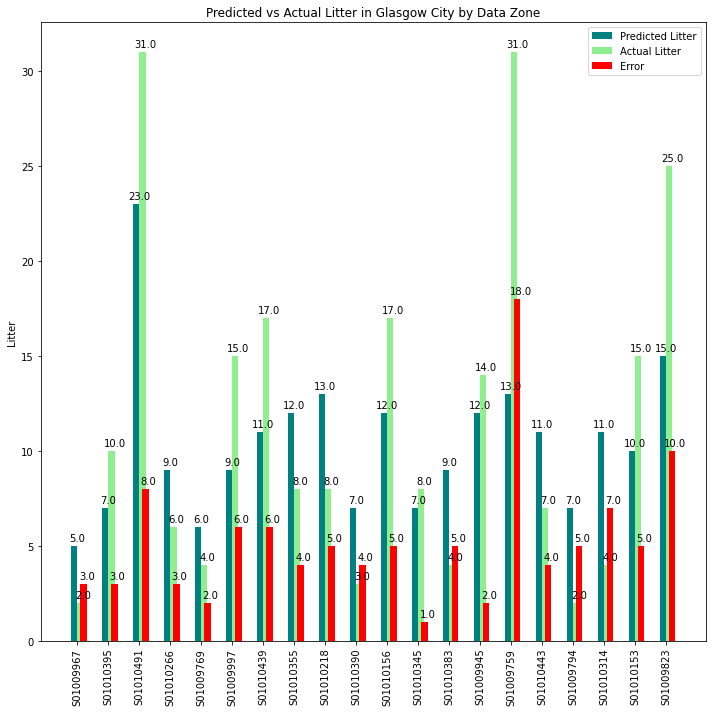

In [153]:
y_valid, X_valid = dmatrices(nb_model_formula, df_valid, return_type="dataframe")
nb_model_valid = sm.GLM(y_valid, X_valid, family=sm.families.NegativeBinomial(alpha=0.4)).fit()
print(nb_model_valid.summary())
print("AIC:", nb_model_valid.aic)
check_pearson_chi2(pearson_chi2=nb_model_valid.pearson_chi2, residuals=nb_model_valid.df_resid)
scatter_plot(df_valid, nb_model_formula, nb_model_valid)
bar_plot(df_valid, nb_model_formula, nb_model_valid)

### Bonferroni Correction

Apply Bonferroni correction to the p-values to account for significant by random chance.

In [154]:
from statsmodels.stats.multitest import multipletests
reject, corrected_pvalues, _, _ = multipletests(nb_model_valid.pvalues, alpha=0.05, method="bonferroni")
print(nb_model_valid.pvalues)
print(corrected_pvalues)
print(reject)

Intercept            0.000000
ALCOHOL              0.547712
SMR                  0.962061
Attainment           0.192791
DEPRESS              0.757558
EMERG                0.343194
employment_rate      0.402859
CIF                  0.297607
Attendance           0.899486
income_rate          0.968878
no_qualifications    0.000131
dtype: float64
[0.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.00144456]
[ True False False False False False False False False False  True]


### Test

Apply to the test data set.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 litter   No. Observations:                   75
Model:                            GLM   Df Residuals:                       64
Model Family:        NegativeBinomial   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -219.09
Date:                Sat, 16 Apr 2022   Deviance:                       38.068
Time:                        20:41:44   Pearson chi2:                     35.3
No. Iterations:                     8   Pseudo R-squ. (CS):             0.3929
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.1348      0.08

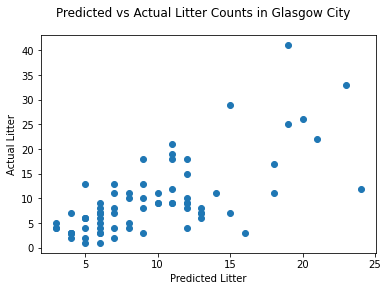

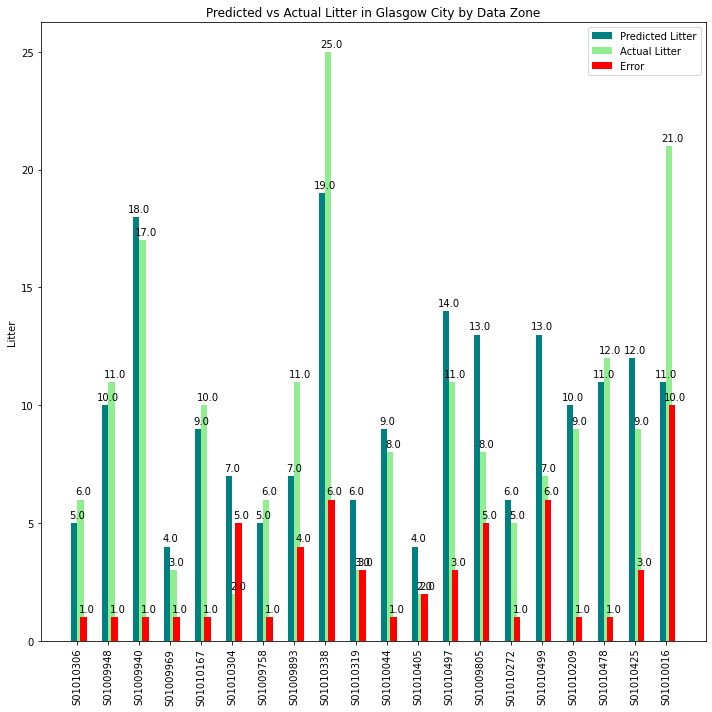

In [155]:
y_test, X_test = dmatrices(nb_model_formula, df_test, return_type="dataframe")
nb_model_test = sm.GLM(y_test, X_test, family=sm.families.NegativeBinomial(alpha=0.4)).fit()
print(nb_model_test.summary())
print("AIC:", nb_model_test.aic)
check_pearson_chi2(pearson_chi2=nb_model_test.pearson_chi2, residuals=nb_model_test.df_resid)
scatter_plot(df_test, nb_model_formula, nb_model_test)
bar_plot(df_test, nb_model_formula, nb_model_test)

In [156]:
reject, corrected_pvalues, _, _ = multipletests(nb_model_test.pvalues, alpha=0.05, method="bonferroni")
print(nb_model_test.pvalues)
print(corrected_pvalues)
print(reject)

Intercept            2.221945e-141
ALCOHOL               1.041223e-01
SMR                   3.030750e-01
Attainment            6.635072e-01
DEPRESS               2.402357e-01
EMERG                 8.519794e-01
employment_rate       6.549195e-01
CIF                   4.126146e-01
Attendance            4.506981e-01
income_rate           3.700633e-01
no_qualifications     7.448594e-01
dtype: float64
[2.44413915e-140 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000]
[ True False False False False False False False False False False]
